## Download the Dataset

In [ ]:
import tifffile
from pathlib import Path
import sys
import matplotlib.pyplot as plt
sys.path.append('library')

import library.dataset as dataset

await dataset.load_jump_dataset("notebooks/data/jump/noisy.tiff")

Loading BSD68 Dataset
BSD68 Dataset Loaded at  notebooks\data\bsd68


## Visualize the Dataset

Image shape: (517, 4, 540, 540)


Text(0.5, 1.0, 'Channel 4')

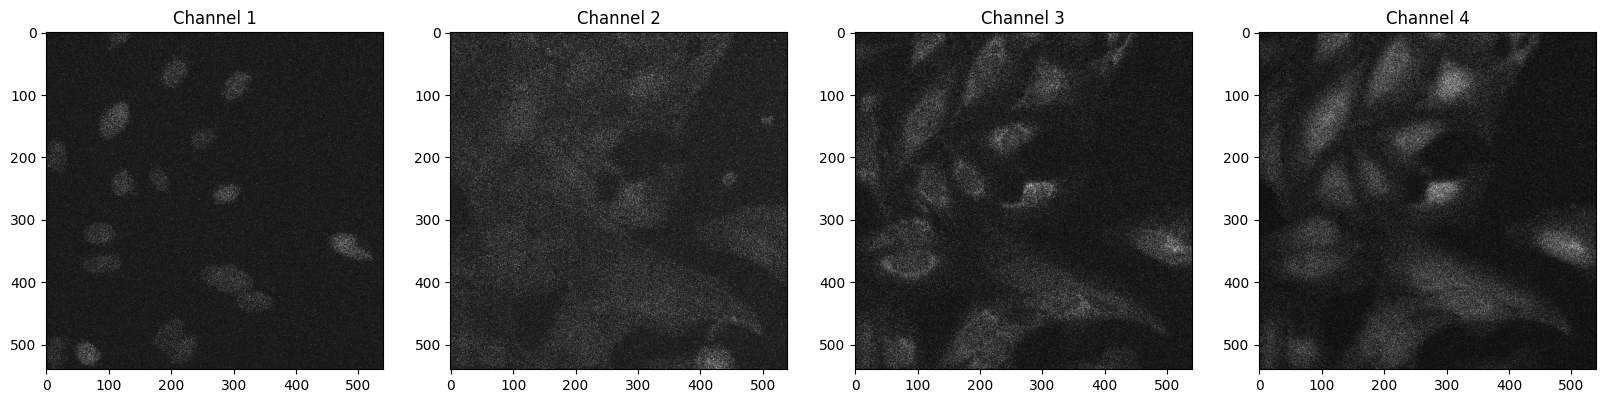

In [26]:
# load training and validation image and show them side by side
train_image = tifffile.imread("notebooks/data/jump/noisy.tiff")
print(f"Image shape: {train_image.shape}")

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(train_image[0][0], cmap="gray")
ax[0].set_title("Channel 1")
ax[1].imshow(train_image[0][1], cmap="gray")
ax[1].set_title("Channel 2")
ax[2].imshow(train_image[0][2], cmap="gray")
ax[2].set_title("Channel 3")
ax[3].imshow(train_image[0][3], cmap="gray")
ax[3].set_title("Channel 4")